In [1]:
# A demo for Graph visualization with TensorBoard
# https://www.tensorflow.org/get_started/summaries_and_tensorboard

In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import os
import time
import numpy as np
import tensorflow as tf

In [4]:
# Step1 load MNITST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

/home/mzx/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [7]:
def nn_layer(x, l_in, l_out, l_name, 
             act_fn, BN_flag=True):
    with tf.name_scope(l_name):
        with tf.name_scope('weights'):
            W = weight_variable(shape=[l_in, l_out])
            variable_summaries(W)
        with tf.name_scope('biases'):
            b = bias_variable(shape=[l_out])
            variable_summaries(b)
        with tf.name_scope('Wx_plus_b'):
            x_h = tf.matmul(x, W) + b
            tf.summary.histogram('x_h', x_h)
        if BN_flag:
            with tf.name_scope('BatchNorm'):  
                axis = list(range(len(x.get_shape()) - 1))
                mean,var = tf.nn.moments(x_h, axis)
                with tf.name_scope('gamma'):
                    gamma = tf.Variable(
                        tf.constant(0.1, shape=mean.get_shape()))
                    variable_summaries(gamma)
                with tf.name_scope('beta'):
                    beta = tf.Variable(
                        tf.constant(0.1, shape=mean.get_shape()))
                    variable_summaries(beta)
                y = tf.nn.batch_normalization(
                    x = x_h,
                    mean = mean,
                    variance = var,
                    offset = beta,
                    scale = gamma,
                    variance_epsilon = 1e-5,
                    name= 'BN')
                tf.summary.histogram('y', y)
            with tf.name_scope('activation'):
                y_act = act_fn(y)
                tf.summary.histogram('activation', y_act)
        else:
            with tf.name_scope('activation'):
                y_act = act_fn(x_h)
                tf.summary.histogram('activation', y_act)
   
    return y_act  

In [8]:
def dropout_layer(layer, keep_prob):
    with tf.name_scope('dropout'):
        y_dropout = tf.nn.dropout(layer, keep_prob)
    return y_dropout

In [9]:
# Build a softmax regression model
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10]) # one-hot 10-dimensional vector
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    tf.summary.scalar('dropout_keep_probability', keep_prob)

In [10]:
# Layers
# Refer to tf.nn.moments
# FC1
l_FC1 = 512
y_FC1 = nn_layer(x=x, l_in = 784, l_out=512, 
                 l_name='FC1',
                 act_fn=tf.nn.relu, BN_flag=False)
y_FC1_drop = dropout_layer(y_FC1, keep_prob)

In [11]:
# FC2
l_FC2 = 256
y_FC2 = nn_layer(x=y_FC1_drop, l_in = l_FC1, 
                 l_out=l_FC2, l_name='FC2',
                 act_fn=tf.nn.relu, BN_flag=False)
y_FC2_drop = dropout_layer(y_FC2, keep_prob)

In [12]:
# FC3
l_FC3 = 128
y_FC3 = nn_layer(x=y_FC2_drop, l_in = l_FC2, 
                 l_out=l_FC3, l_name='FC3',
                 act_fn=tf.nn.relu, BN_flag=False)
y_FC3_drop = dropout_layer(y_FC3, keep_prob)

In [13]:
# softmax
l_s = 10
y = nn_layer(x=y_FC3_drop, l_in = l_FC3, 
             l_out=l_s, l_name='softmax',
             act_fn=tf.nn.tanh, BN_flag=False)

In [14]:
# loss function
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
tf.summary.scalar('loss', cross_entropy)

<tf.Tensor 'loss_1:0' shape=() dtype=string>

In [15]:
# learning rate
with tf.name_scope('train'):
    with tf.name_scope('learning_rate'):
        init_lr = tf.placeholder(tf.float32, name='LR')
        global_step = tf.placeholder(tf.float32, name="global_step")
        decay_step = tf.placeholder(tf.float32, name="decay_step")
        decay_rate = tf.placeholder(tf.float32, name="decay_rate")
        learning_rate = tf.train.exponential_decay(
            learning_rate = init_lr ,
            global_step = global_step,
            decay_steps = decay_step,
            decay_rate = decay_rate,
            staircase=False,
            name=None)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

In [16]:
# Accuracy
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(
            tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [17]:
# Initialize the variables
sess = tf.InteractiveSession()

In [18]:
# Merge all the summaries and write to logdir
logdir = './log'
if not os.path.exists(logdir):
    os.mkdir(logdir)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train',
                                      sess.graph)
val_writer = tf.summary.FileWriter(logdir + '/validation',
                                   sess.graph)
test_writer = tf.summary.FileWriter(logdir + '/test',
                                   sess.graph)
sess.run(tf.global_variables_initializer())

In [19]:
def feed_dict(train,batchsize=100,drop=0.5, lr_dict=None):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
        xs, ys = mnist.train.next_batch(batchsize)
        f_dict = {x: xs, y_: ys, 
                  keep_prob: drop, 
                  }
        f_dict.update(lr_dict)
    else:    
        # validation
        x_val,y_val = mnist.validation.images,mnist.validation.labels
        f_dict = {x: x_val,y_: y_val,
                  keep_prob: 1.0,
                  }
    return f_dict

In [20]:
def test_dict():
    xs, ys = mnist.test.images, mnist.test.labels
    f_dict = {x: xs, y_: ys, 
              keep_prob:1.0,
              }
    return f_dict

In [21]:
# Training the model by repeatedly running train_step
import time 
epochs = 100
batchsize= 100
# num_batches = mnist.train.images.shape[0] // batchsize
num_batches = 200

lr_init = 0.01
d_rate = 0.9

x_epoch = np.arange(0,epochs,1)
y_loss_trn = np.zeros(x_epoch.shape)
y_acc_trn = np.zeros(x_epoch.shape)
y_loss_val = np.zeros(x_epoch.shape)
y_acc_val = np.zeros(x_epoch.shape)
y_acc_test = np.zeros(x_epoch.shape)

# Init all variables
timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
print("[%s]: Epochs    Trn_loss    Val_loss    Trn_acc    Val_acc    Test_acc" % (timestamp))
for i in range(epochs):
    lr_dict = {init_lr: lr_init, global_step:i,
               decay_step: i, decay_step: batchsize,
               decay_rate: d_rate}
    loss_trn_all = 0.0
    acc_trn_all = 0.0
    for b in range(num_batches):
        train_dict = feed_dict(True,lr_dict=lr_dict)
        # train
        summary_trn, _, acc_trn, loss_trn = sess.run(
            [merged, train_step, accuracy, cross_entropy], 
            feed_dict=train_dict)
        loss_trn_all += loss_trn
        acc_trn_all += acc_trn
    
    y_loss_trn[i] = loss_trn_all / num_batches
    y_acc_trn[i] = acc_trn_all / num_batches
    train_writer.add_summary(summary_trn, i)
    # validation
    val_dict = feed_dict(False)
    summary_val, y_acc_val[i], y_loss_val[i] = sess.run(
        [merged, accuracy, cross_entropy],feed_dict=val_dict)
    val_writer.add_summary(summary_val, i)
    summary, y_acc_test[i] = sess.run(
        [merged, accuracy],feed_dict=test_dict())
    test_writer.add_summary(summary, i)
    if i % 10 == 0:
        timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
        print('[%s]: %d    %.4f    %.4f    %.4f    %.4f    %.4f' % (timestamp, i, 
                                                                    y_loss_trn[i], y_loss_val[i],
                                                                    y_acc_trn[i], y_acc_val[i],
                                                                    y_acc_test[i]))

[2018-01-25: 16:59:13]: Epochs    Trn_loss    Val_loss    Trn_acc    Val_acc    Test_acc
[2018-01-25: 16:59:17]: 0    2.4071    2.2555    0.1235    0.2984    0.2849
[2018-01-25: 16:59:58]: 10    1.5330    1.2920    0.5502    0.7990    0.7875
[2018-01-25: 17:00:38]: 20    1.2941    1.1012    0.6955    0.8416    0.8368
[2018-01-25: 17:01:19]: 30    1.2089    1.0396    0.7506    0.8608    0.8598
[2018-01-25: 17:01:59]: 40    1.1501    1.0114    0.7804    0.8650    0.8640
[2018-01-25: 17:02:39]: 50    1.1204    0.9945    0.7983    0.8760    0.8726
[2018-01-25: 17:03:19]: 60    1.0944    0.9822    0.8116    0.8792    0.8760
[2018-01-25: 17:03:59]: 70    1.0706    0.9711    0.8268    0.8972    0.8942
[2018-01-25: 17:04:39]: 80    1.0530    0.9589    0.8470    0.9134    0.9129
[2018-01-25: 17:05:19]: 90    1.0396    0.9401    0.8580    0.9232    0.9220


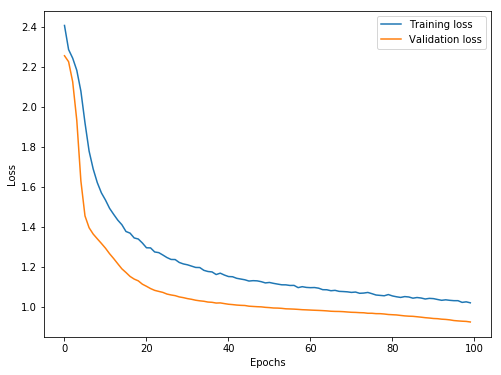

In [22]:
plt.rcParams["figure.figsize"] = [8.0,6.0]

plt.plot(x_epoch, y_loss_trn)
plt.plot(x_epoch, y_loss_val)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

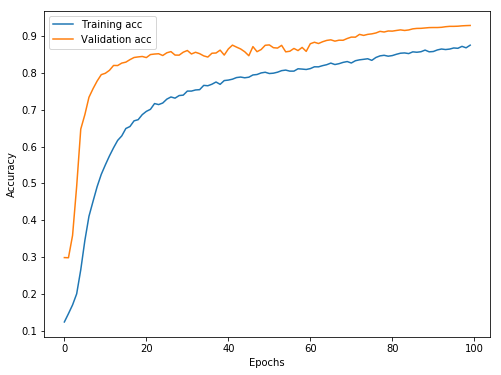

In [23]:
plt.rcParams["figure.figsize"] = [8.0,6.0]

plt.plot(x_epoch, y_acc_trn)
plt.plot(x_epoch, y_acc_val)
plt.legend(['Training acc', 'Validation acc', 'Test acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')